# Data Preparation & Profiling

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data
colnames = ['ProductID','Product_type','Date','Price','Quantity']
# df = pd.read_excel('beer.xlsx', names=colnames, header=None)
df = pd.read_csv('data/beer-neue-2.csv', names=colnames, header=None, encoding="utf-8",)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ProductID     875 non-null    object 
 1   Product_type  875 non-null    object 
 2   Date          875 non-null    object 
 3   Price         875 non-null    float64
 4   Quantity      875 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 34.3+ KB


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df.head(10)

ProductID Product_type        Date  Price  Quantity
0     S0001         Beer  2017-01-01  10.37        59
1     L0001         Beer  2017-01-01  11.79        51
2     C5007         Beer  2017-01-01  10.02        76
3     C4410         Beer  2017-01-01  12.38        45
4     C6799         Beer  2017-01-01  11.84        50
5     C6946         Beer  2017-01-01  11.88        56
6     C8456         Beer  2017-01-01  10.80        70
7     C5041         Beer  2017-01-01  10.63        62
8     C8945         Beer  2017-01-01  10.58        59
9     C8644         Beer  2017-01-01  10.59        67

In [6]:
df.shape

(875, 5)

# Exploratory Data Analysis

In [7]:
#Check values in different category_name
category = df['Product_type'].value_counts()
category

Beer    875
Name: Product_type, dtype: int64

In [8]:
#Select Cereals

#Select Cereals
df_feature = df[df['Product_type']=='Beer']

#Make sure to not have any duplicates in the data
df_feature = df_feature.groupby(['Date','ProductID']).agg({'Price':'mean','Quantity': 'mean' }).reset_index()

#laptop data used for price elasticities
df_feature.head()

Date ProductID  Price  Quantity
0  2017-01-01     C1021   8.61      20.0
1  2017-01-01     C1033   9.08      19.0
2  2017-01-01     C1037   8.56      19.0
3  2017-01-01     C1054   9.14      17.0
4  2017-01-01     C1075   8.00      27.0

# Data Modelling

In [9]:
#Format and build a dataframe with x_values for each product within the category
x_pivot = df_feature.pivot( index='Date', columns='ProductID' ,values='Price' )
x_values = pd.DataFrame(x_pivot.to_records())
x_values.dropna()
print(x_values)

         Date  C1021  C1023  C1033  C1037  C1054  C1075  C1130  C1178  C1204  \
0  2017-01-01   8.61    NaN   9.08   8.56   9.14   8.00   9.52   8.72    NaN   
1  2017-01-02   9.26  14.61  10.09   8.54   8.40   8.63   9.22   9.74  11.21   
2  2017-01-03    NaN  13.68    NaN    NaN    NaN   8.97    NaN    NaN   9.08   

   ...  H9113   H931  H9403  H9425  H9660  H9666  H9722  H9878  L0001  S0001  
0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  11.79  10.37  
1  ...  82.66  65.07  90.78  63.95  52.98  59.80  70.38  51.99  12.21  12.54  
2  ...  92.48  61.86  85.57  58.54  62.61  66.88  64.36  61.98  10.68  11.28  

[3 rows x 421 columns]


In [10]:
#Format and build a dataframe with y_values for each product within the category
y_pivot = df_feature.pivot( index='Date', columns='ProductID' ,values='Quantity' )
y_values = pd.DataFrame(y_pivot.to_records())
y_values.dropna()
print(y_values)

         Date  C1021  C1023  C1033  C1037  C1054  C1075  C1130  C1178  C1204  \
0  2017-01-01   20.0    NaN   19.0   19.0   17.0   27.0   16.0   19.0    NaN   
1  2017-01-02    6.0   50.0    4.0   10.0   10.0    8.0    6.0    5.0   25.0   
2  2017-01-03    NaN   57.0    NaN    NaN    NaN    7.0    NaN    NaN   37.0   

   ...  H9113  H931  H9403  H9425  H9660  H9666  H9722  H9878  L0001  S0001  
0  ...    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   51.0   59.0  
1  ...   29.0   5.0   22.0    6.0   11.0    9.0    5.0   11.0   21.0   21.0  
2  ...   22.0   7.0   28.0   10.0    6.0    5.0    6.0    6.0   30.0   25.0  

[3 rows x 421 columns]


In [11]:
points = []
results_values = {
    "ProductID": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
}
#Append x_values with y_values per same product name
for column in x_values.columns[1:]:
    column_points = []
    for i in range(len(x_values[column])):
        if not np.isnan(x_values[column][i]) and not np.isnan(y_values[column][i]):
            column_points.append((x_values[column][i], y_values[column][i]))
    df = pd.DataFrame(list(column_points), columns= ['x_value', 'y_value'])
    

    #Linear Regression Model
    import statsmodels.api as sm
    x_value = df['x_value']
    y_value = df['y_value']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()
    

    #(Null Hypothesis test) Coefficient with a p value less than 0.05
    if result.f_pvalue < 0.25:
        
        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        intercept, slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        tintercept, t_score = result.tvalues
     
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)    
            
        #Append results into dictionary for dataframe
        results_values["ProductID"].append(column)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        
final_df = pd.DataFrame.from_dict(results_values)

print(result.f_pvalue)
print(final_df)


0.3313747999192882
  ProductID  price_elasticity  price_mean  quantity_mean    intercept  \
0     C1075        -13.298473    8.533333      14.000000   200.178616   
1     C2178          4.851334    9.113333       9.333333   -35.945783   
2     C2883         20.621975   11.660000      34.000000  -667.147165   
3     C3539          3.097761   11.173333      35.666667   -74.820131   
4     C5041         15.374513   10.270000      40.333333  -579.772011   
5     C6142        -14.163386    9.083333      11.666667   176.906166   
6     C7693        -88.917247    8.613333      12.333333  1108.979381   
7     C9015        -14.415648    9.193333      10.333333   159.295032   

     t_score       slope  coefficient_pvalue  
0  -3.140271  -21.817807            0.196264  
1   2.933989    4.968447            0.209120  
2  15.557249   60.132690            0.040865  
3   3.026571    9.888437            0.203155  
4   9.927608   60.380267            0.063911  
5  -5.376706  -18.191504            0.117

In [12]:
df_elasticity = final_df[['ProductID','price_elasticity','t_score','coefficient_pvalue','slope','price_mean','quantity_mean','intercept']]
df_elasticity

ProductID  price_elasticity    t_score  coefficient_pvalue       slope  \
0     C1075        -13.298473  -3.140271            0.196264  -21.817807   
1     C2178          4.851334   2.933989            0.209120    4.968447   
2     C2883         20.621975  15.557249            0.040865   60.132690   
3     C3539          3.097761   3.026571            0.203155    9.888437   
4     C5041         15.374513   9.927608            0.063911   60.380267   
5     C6142        -14.163386  -5.376706            0.117066  -18.191504   
6     C7693        -88.917247  -3.656552            0.169948 -127.319588   
7     C9015        -14.415648  -5.289596            0.118949  -16.203230   

   price_mean  quantity_mean    intercept  
0    8.533333      14.000000   200.178616  
1    9.113333       9.333333   -35.945783  
2   11.660000      34.000000  -667.147165  
3   11.173333      35.666667   -74.820131  
4   10.270000      40.333333  -579.772011  
5    9.083333      11.666667   176.906166  
6    8.613333      12.333333  1108.979381  
7    9.193333      10.333333   159.295032

In [13]:
def divergent_plot(df, values_column, ylabel, xlabel):

    #Divergent plot
    df['ranking'] = df[values_column].rank( ascending = True).astype(int)
    df.sort_values(values_column, ascending =False, inplace = True)
    plt.figure(figsize = (12,5), dpi = 80)
    plt.hlines(y = df['ranking'] , xmin = 0, xmax = df[values_column], alpha = 0.5, linewidth = 3)
    
    #Add elasticity labels
    for x, y, tex in zip(df[values_column], df['ranking'] , df[values_column]):
        plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':10})
        
    
    # Axis and title
    plt.gca().set(ylabel= ylabel, xlabel= xlabel)
    plt.yticks(df['ranking'])
    plt.title(values_column , fontdict={'size':13})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()
            
    
    #Adjust Ranking column and print dataframe
    pd.set_option('display.width', 4000)
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    
    df = df.iloc[:,:3]
    df.set_index('ranking', inplace=True)
    display(df)

# Result

In [14]:
df_elasticity

ProductID  price_elasticity    t_score  coefficient_pvalue       slope  \
0     C1075        -13.298473  -3.140271            0.196264  -21.817807   
1     C2178          4.851334   2.933989            0.209120    4.968447   
2     C2883         20.621975  15.557249            0.040865   60.132690   
3     C3539          3.097761   3.026571            0.203155    9.888437   
4     C5041         15.374513   9.927608            0.063911   60.380267   
5     C6142        -14.163386  -5.376706            0.117066  -18.191504   
6     C7693        -88.917247  -3.656552            0.169948 -127.319588   
7     C9015        -14.415648  -5.289596            0.118949  -16.203230   

   price_mean  quantity_mean    intercept  
0    8.533333      14.000000   200.178616  
1    9.113333       9.333333   -35.945783  
2   11.660000      34.000000  -667.147165  
3   11.173333      35.666667   -74.820131  
4   10.270000      40.333333  -579.772011  
5    9.083333      11.666667   176.906166  
6    8.613333      12.333333  1108.979381  
7    9.193333      10.333333   159.295032

In [15]:
df_sample = df_elasticity.head(10).append(df_elasticity.tail(10))
df_sample

ProductID  price_elasticity    t_score  coefficient_pvalue       slope  \
0     C1075        -13.298473  -3.140271            0.196264  -21.817807   
1     C2178          4.851334   2.933989            0.209120    4.968447   
2     C2883         20.621975  15.557249            0.040865   60.132690   
3     C3539          3.097761   3.026571            0.203155    9.888437   
4     C5041         15.374513   9.927608            0.063911   60.380267   
5     C6142        -14.163386  -5.376706            0.117066  -18.191504   
6     C7693        -88.917247  -3.656552            0.169948 -127.319588   
7     C9015        -14.415648  -5.289596            0.118949  -16.203230   
0     C1075        -13.298473  -3.140271            0.196264  -21.817807   
1     C2178          4.851334   2.933989            0.209120    4.968447   
2     C2883         20.621975  15.557249            0.040865   60.132690   
3     C3539          3.097761   3.026571            0.203155    9.888437   
4     C5041         15.374513   9.927608            0.063911   60.380267   
5     C6142        -14.163386  -5.376706            0.117066  -18.191504   
6     C7693        -88.917247  -3.656552            0.169948 -127.319588   
7     C9015        -14.415648  -5.289596            0.118949  -16.203230   

   price_mean  quantity_mean    intercept  
0    8.533333      14.000000   200.178616  
1    9.113333       9.333333   -35.945783  
2   11.660000      34.000000  -667.147165  
3   11.173333      35.666667   -74.820131  
4   10.270000      40.333333  -579.772011  
5    9.083333      11.666667   176.906166  
6    8.613333      12.333333  1108.979381  
7    9.193333      10.333333   159.295032  
0    8.533333      14.000000   200.178616  
1    9.113333       9.333333   -35.945783  
2   11.660000      34.000000  -667.147165  
3   11.173333      35.666667   -74.820131  
4   10.270000      40.333333  -579.772011  
5    9.083333      11.666667   176.906166  
6    8.613333      12.333333  1108.979381  
7    9.193333      10.333333   159.295032

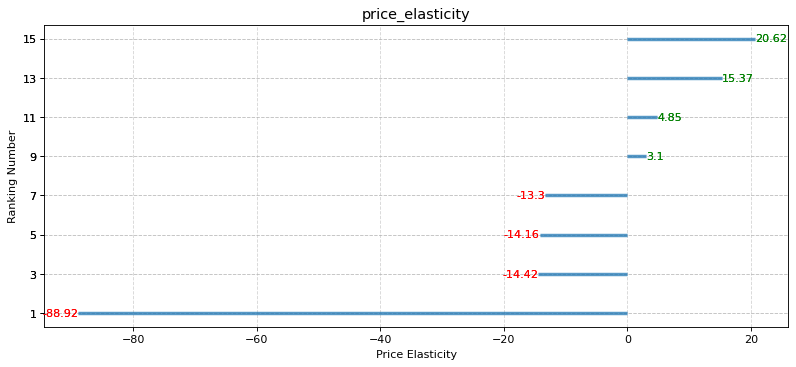

ProductID  price_elasticity
ranking                            
15          C2883         20.621975
15          C2883         20.621975
13          C5041         15.374513
13          C5041         15.374513
11          C2178          4.851334
11          C2178          4.851334
9           C3539          3.097761
9           C3539          3.097761
7           C1075        -13.298473
7           C1075        -13.298473
5           C6142        -14.163386
5           C6142        -14.163386
3           C9015        -14.415648
3           C9015        -14.415648
1           C7693        -88.917247
1           C7693        -88.917247

In [18]:
pe_plot = divergent_plot(df_sample, 'price_elasticity', 'Ranking Number', 'Price Elasticity')

* Elasticities between 0- 1 are considered inelastic, as a result the products from rank 1 to 20 are elastic.
* Negative Price Elasticities are located from rank 1 to 20 and this would tell us the likelihood of when price decreases how likely sales demand would increase or vice versa.
* For instance, let’s analyze C1021 located in rank 11 with a negative price elasticity of -1.867437 ; a 10% price decrease in C1021, it increases sales demand by 18.67% or a 10% price increase in C1021, it decreases sales demand by 18.67%